In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv
/kaggle/input/child-mind-institute-problematic-internet-use/data_dictionary.csv
/kaggle/input/child-mind-institute-problematic-internet-use/train.csv
/kaggle/input/child-mind-institute-problematic-internet-use/test.csv
/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet/id=00115b9f/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet/id=001f3379/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=0745c390/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=eaab7a96/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=8ec2cc63/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=b2987a65/part-0.parquet
/kaggle/input/child-mind-institute-problematic-intern

## Understanding the Task

In this competition, we aim to predict the **Severity Impairment Index (SII)**, a measure derived from the **Parent-Child Internet Addiction Test (PCIAT)**. The SII reflects the degree of problematic internet use in participants aged 5-22, based on various clinical and behavioral data. 

The dataset comes from the **Healthy Brain Network (HBN)** study, which includes comprehensive clinical and research screenings. Our task is to leverage two primary data sources:
- **Actigraphy Data**: Time-series data captured by a wrist-worn accelerometer over a period of up to 30 days.
- **Tabular Data**: Demographic, physical, behavioral, and mental health measurements gathered from various clinical instruments, including:
  - **Demographics** (age, sex)
  - **Physical Activity Questionnaires**
  - **Fitness and Physical Measures**
  - **Sleep Disturbance Scales**
  - **Internet Usage Behavior** (daily hours of use)

The target variable, **SII**, ranges from:
- `0` for None
- `1` for Mild
- `2` for Moderate
- `3` for Severe

The primary challenge is that the majority of participants have missing values in many fields, and a portion of the training data lacks SII labels. The test data contains complete SII values, which are withheld during the competition.

### Data Files
- **series_train.parquet / series_test.parquet**: Continuous accelerometer readings (actigraphy) for each participant. Each file contains:
  - **X, Y, Z**: Raw accelerometer readings.
  - **ENMO**: Calculated metric of movement intensity.
  - **AngleZ**: Arm position relative to the horizontal plane.
  - **non-wear_flag**: Whether the accelerometer was not worn (0 = worn, 1 = not worn).
  - **Light**: Ambient light level in lux.
  - **Time of Day**: Time of recording, broken down into seconds.
  
- **train.csv / test.csv**: Tabular data including demographics, internet usage, and clinical measures.
- **data_dictionary.csv**: Descriptions of all fields and clinical instruments used in the study.

### Goal
Using the combination of actigraphy data and tabular clinical measures, your goal is to predict each participant's **Severity Impairment Index (SII)**, identifying patterns that link physical activity, fitness, and internet usage behaviors with internet addiction severity.



# Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

sns.set(style="whitegrid")

# Importing Data

In [3]:
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
data_dict = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/data_dictionary.csv')

In [4]:
print(train.head())
print(test.head())
print(data_dict.head())

         id Basic_Demos-Enroll_Season  Basic_Demos-Age  Basic_Demos-Sex  \
0  00008ff9                      Fall                5                0   
1  000fd460                    Summer                9                0   
2  00105258                    Summer               10                1   
3  00115b9f                    Winter                9                0   
4  0016bb22                    Spring               18                1   

  CGAS-Season  CGAS-CGAS_Score Physical-Season  Physical-BMI  Physical-Height  \
0      Winter             51.0            Fall     16.877316             46.0   
1         NaN              NaN            Fall     14.035590             48.0   
2        Fall             71.0            Fall     16.648696             56.5   
3        Fall             71.0          Summer     18.292347             56.0   
4      Summer              NaN             NaN           NaN              NaN   

   Physical-Weight  ...  PCIAT-PCIAT_18  PCIAT-PCIAT_19  PCIAT

# Explority Data Analysis

## Examine the Importance of Each Column

1. **Critical Columns**  
   Critical columns (e.g., `Basic_Demos-Age`, `Basic_Demos-Sex`, `PreInt_EduHx-computerinternet_hoursday`) should be preserved or imputed as they are likely important for predicting **SII**. These columns may have a significant impact on the model's performance and the overall prediction accuracy.

2. **Columns with a Lot of Missing Data**  
   Columns with a high percentage of missing data, such as `CGAS-Season` and `SDS-SDS_Total_T`, require special handling. If the missing data exceeds a certain threshold, they could be candidates for dropping. Alternatively, imputation strategies may be considered depending on the importance of these variables and the overall data quality.


## Handle Missing Data 

In [5]:
print(train.isnull().sum())
print(test.isnull().sum())

id                                           0
Basic_Demos-Enroll_Season                    0
Basic_Demos-Age                              0
Basic_Demos-Sex                              0
CGAS-Season                               1405
                                          ... 
SDS-SDS_Total_Raw                         1351
SDS-SDS_Total_T                           1354
PreInt_EduHx-Season                        420
PreInt_EduHx-computerinternet_hoursday     659
sii                                       1224
Length: 82, dtype: int64
id                                         0
Basic_Demos-Enroll_Season                  0
Basic_Demos-Age                            0
Basic_Demos-Sex                            0
CGAS-Season                               10
CGAS-CGAS_Score                           12
Physical-Season                            6
Physical-BMI                               7
Physical-Height                            7
Physical-Weight                            7
Physical

In [6]:
print("Training columns:")
print(train.columns.tolist())

print("\nTesting columns:")
print(test.columns.tolist())

Training columns:
['id', 'Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI', 'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference', 'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP', 'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec', 'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season', 'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Sea

In [7]:
num = train.select_dtypes(include=np.number)
cat = train.select_dtypes(include=['object'])


In [8]:
num.isnull().sum()

Basic_Demos-Age                              0
Basic_Demos-Sex                              0
CGAS-CGAS_Score                           1539
Physical-BMI                               938
Physical-Height                            933
                                          ... 
PCIAT-PCIAT_Total                         1224
SDS-SDS_Total_Raw                         1351
SDS-SDS_Total_T                           1354
PreInt_EduHx-computerinternet_hoursday     659
sii                                       1224
Length: 70, dtype: int64

In [9]:
missing_percentage = (train.isnull().sum() / len(train)) * 100
print(missing_percentage[missing_percentage >= 0].sort_values(ascending=False))


PAQ_A-PAQ_A_Total              88.005051
PAQ_A-Season                   88.005051
Fitness_Endurance-Time_Sec     81.313131
Fitness_Endurance-Time_Mins    81.313131
Fitness_Endurance-Max_Stage    81.237374
                                 ...    
PreInt_EduHx-Season            10.606061
Basic_Demos-Enroll_Season       0.000000
Basic_Demos-Sex                 0.000000
Basic_Demos-Age                 0.000000
id                              0.000000
Length: 82, dtype: float64


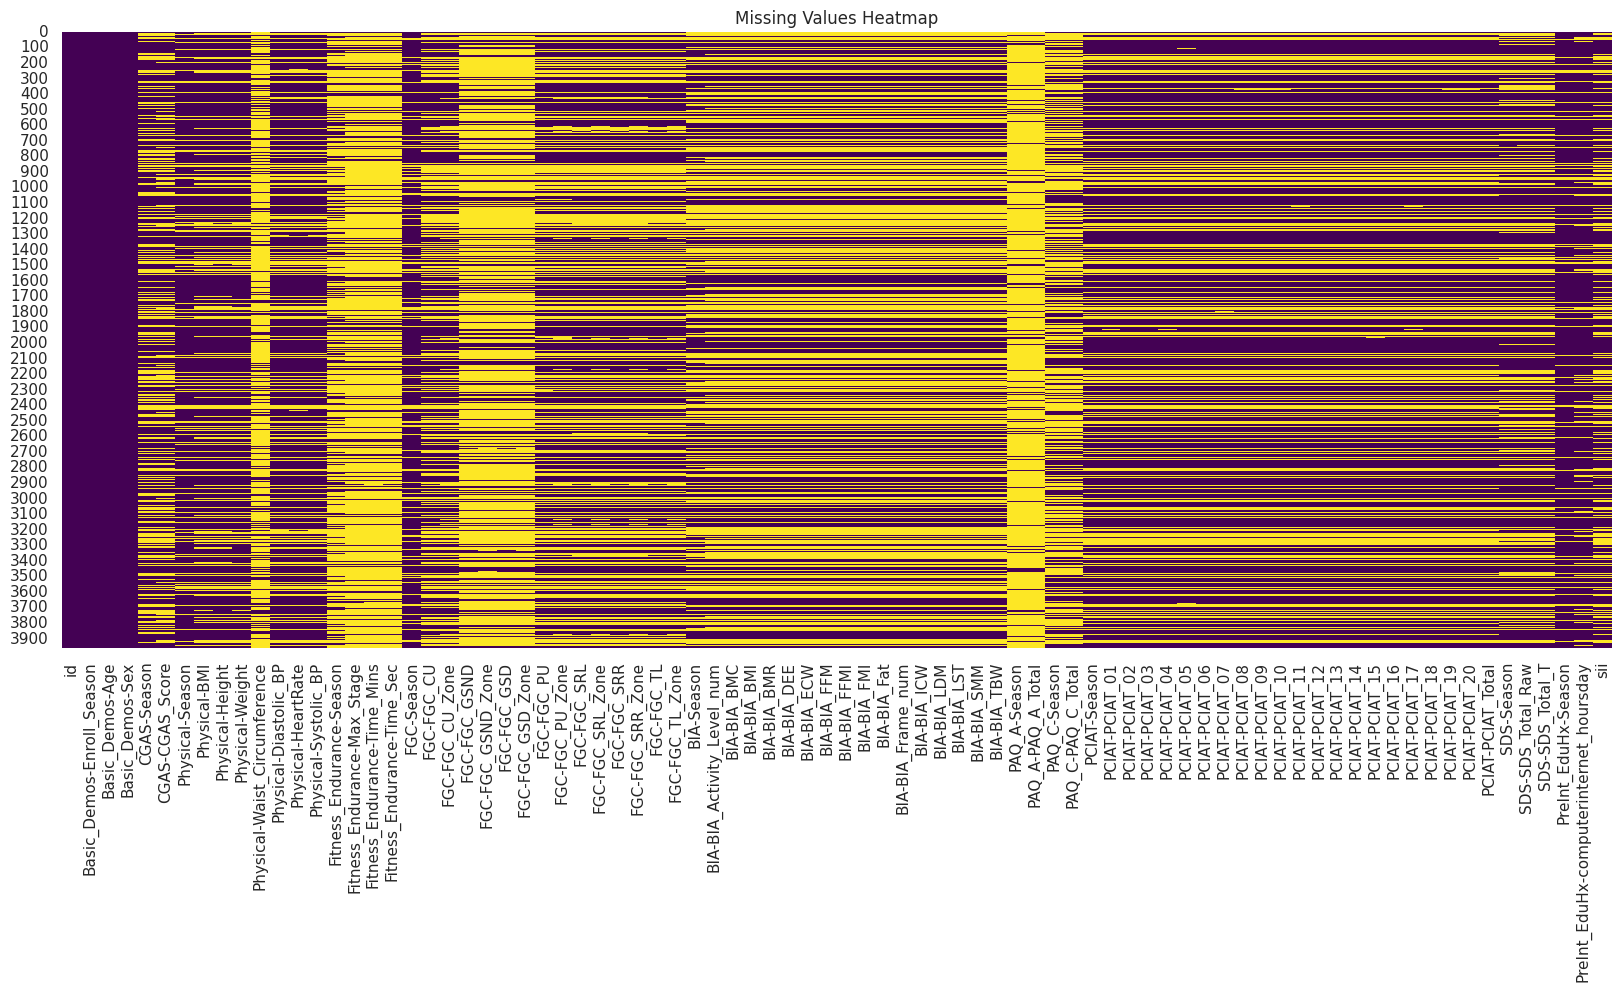

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 8))
sns.heatmap(train.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()
